In [1]:
%load_ext autoreload
%autoreload 2

# Generate embeddings

In [2]:
import embedders
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda


In [3]:
# For Lightning - change directory

import os 

if not os.getcwd().endswith("notebooks"):
    os.chdir("embedders/notebooks")
print(os.getcwd())

/teamspace/studios/this_studio/embedders/notebooks


The relevant quote from the Tabaghi paper:

<blockquote>
To embed these datasets into different product space forms, we adapted and modified the
mixed-curvature VAEs algorithm of (Skopek et al., 2020). The original implementation of
this algorithm does not allow the users to choose the number of layers and hidden dimensions
of the network. So we introduce customized changes to make the approach suitable for use
with datasets at different scales. For the Lymphoma dataset, we use two MLP layers with
hidden dimension 200 and train the network for 500 epochs. For the blood cell landmark
dataset, we use three MLP layers with hidden dimension 400 and train the network for 200
epochs. Other experimental setups are the same as the ones stated in (Skopek et al., 2020).
</blockquote>

In [4]:
class Encoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(967, 400)
        self.fc2 = torch.nn.Linear(400, 400)
        self.fc3 = torch.nn.Linear(400, 400)
        self.fc4_z_mean = torch.nn.Linear(400, pm.dim)
        self.fc4_z_logvar = torch.nn.Linear(400, pm.dim)

    def forward(self, x):
        # Hidden layers
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))

        # Reparameterization
        z_mean_tangent = self.fc4_z_mean(h3)
        z_logvar = self.fc4_z_logvar(h3)
        z_mean = pm.manifold.expmap(x=pm.mu0, u=z_mean_tangent @ pm.projection_matrix)

        return z_mean, z_logvar


class Decoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(pm.ambient_dim, 400)
        self.fc2 = torch.nn.Linear(400, 400)
        self.fc3 = torch.nn.Linear(400, 400)
        self.fc4 = torch.nn.Linear(400, 967)

    def forward(self, z):
        # Hidden layers
        h1 = torch.relu(self.fc1(z))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))

        # Output layer
        x = torch.sigmoid(self.fc4(h3))

        return x

In [5]:
# Process X
X, y, _ = embedders.dataloaders.load("blood_cells")
print(X.shape, y.shape)

torch.Size([94655, 967]) torch.Size([94655])


In [6]:
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import numpy as np

SIGNATURE = [(1, 2), (0, 2), (-1, 2), (-1, 2), (-1, 2)]
BATCH_SIZE = 4_096
# BATCH_SIZE = 8_192
N_EPOCHS = 200
BETA = 1.0
N_SAMPLES = 32

# Skopek hyperparamters (aka standard Adam hyperparameters)
LR = 1e-4 # Was 1e-3 but I can't make it work
BETA1 = 0.9
BETA2 = 0.999
EPS = 1e-8
CURVATURE_LR = 1e-4

# Training stuff
TRIALS = 10
CLIP_GRAD = False

# Do train-test split *prior* to embedding to minimize leakage
for trial in range(TRIALS):
    if os.path.exists(f"../data/blood_cell_scrna/embeddings/X_train_{trial}.npy"):
        continue

    # Set seeds
    torch.manual_seed(trial)
    np.random.seed(trial)
    
    # Split now to avoid leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial)

    # Manifold stuff
    pm = embedders.manifolds.ProductManifold(SIGNATURE)
    vae = embedders.vae.ProductSpaceVAE(
        pm=pm, encoder=Encoder(pm), decoder=Decoder(pm), beta=BETA, n_samples=N_SAMPLES, device=device
    )

    # Training stuff
    opt = torch.optim.Adam(
        [
            {"params": vae.parameters(), "lr": LR * 0.1, "betas": (BETA1, BETA2), "eps": EPS},
            {"params": pm.params(), "lr": 0, "betas": (BETA1, BETA2), "eps":  EPS}
        ]
    )

    # Visualization stuff
    my_tqdm = tqdm(total=N_EPOCHS * len(X_train))

    # Device stuff
    vae = vae.to(device)
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    pm = pm.to(device)


    # Gradient checking stuff
    def grads_ok(vae):
        out = True
        for name, param in vae.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN gradient in {name}")
                    out = False
                if torch.isinf(param.grad).any():
                    print(f"Inf gradient in {name}")
                    out = False
        return out


    losses = []
    for epoch in range(N_EPOCHS):
        # Stop the burn-in
        if epoch == 20:
            opt.param_groups[1]["lr"] = CURVATURE_LR
            opt.param_groups[0]["lr"] = LR
        
        for i in range(0, len(X_train), BATCH_SIZE):
            x_batch = X_train[i : i + BATCH_SIZE]

            elbo, ll, kl = vae.elbo(x_batch)
            loss = -elbo
            losses.append(loss.item())

            # Early stopping
            # if len(losses) > 100 and loss.item() > 1.1 * min(losses[-50:]):

            opt.zero_grad()
            loss.backward()

            # Gradient clipping
            if CLIP_GRAD:
                torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
            if torch.isnan(loss):
                print(f"Loss is NaN at iteration {i}")
            elif torch.isinf(loss):
                print(f"Loss is inf at iteration {i}")
            elif grads_ok(vae):
                opt.step()

            my_tqdm.update(BATCH_SIZE)
            my_tqdm.set_description(f"Epoch {epoch}, loss: {loss.item():.1f}, ll: {ll.item():.1f}, kl: {kl.item():.1f}")
            my_tqdm.set_postfix(
                {f"r{i}": f"{x._log_scale.item():.3f}" for i, x in enumerate(pm.manifold.manifolds)}
            )
    
    # Save the embeddings
    embeddings = []
    for i in range(0, len(X_train), BATCH_SIZE):
        x_batch = X_train[i : i + BATCH_SIZE]
        z_mean, _ = vae.encoder(x_batch)
        embeddings.append(z_mean.detach().cpu().numpy())

    embeddings = np.concatenate(embeddings)
    np.save(f"../data/blood_cell_scrna/embeddings/X_train_{trial}.npy", embeddings)
    np.save(f"../data/blood_cell_scrna/embeddings/y_train_{trial}.npy", y_train.detach().cpu().numpy())

    # Save the test embeddings
    embeddings = []
    for i in range(0, len(X_test), BATCH_SIZE):
        x_batch = X_test[i : i + BATCH_SIZE]
        z_mean, _ = vae.encoder(x_batch)
        embeddings.append(z_mean.detach().cpu().numpy())
    
    embeddings = np.concatenate(embeddings)
    np.save(f"../data/blood_cell_scrna/embeddings/X_test_{trial}.npy", embeddings)
    np.save(f"../data/blood_cell_scrna/embeddings/y_test_{trial}.npy", y_test.detach().cpu().numpy())

  0%|          | 0/15144800 [00:00<?, ?it/s]

## Same thing for Lymphoma dataset

In [7]:
class Encoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(1056, 200)
        self.fc2 = torch.nn.Linear(200, 200)
        self.fc3_z_mean = torch.nn.Linear(200, pm.dim)
        self.fc3_z_logvar = torch.nn.Linear(200, pm.dim)

    def forward(self, x):
        # Hidden layers
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))

        # Reparameterization
        z_mean_tangent = self.fc3_z_mean(h2)
        z_logvar = self.fc3_z_logvar(h2)
        z_mean = pm.manifold.expmap(x=pm.mu0, u=z_mean_tangent @ pm.projection_matrix)

        return z_mean, z_logvar


class Decoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(pm.ambient_dim, 200)
        self.fc2 = torch.nn.Linear(200, 200)
        self.fc3 = torch.nn.Linear(200, 1056)

    def forward(self, z):
        # Hidden layers
        h1 = torch.relu(self.fc1(z))
        h2 = torch.relu(self.fc2(h1))

        # Output layer
        x = torch.sigmoid(self.fc3(h2))

        return x

In [8]:
# Process X
X, y, _ = embedders.dataloaders.load("lymphoma")
print(X.shape, y.shape)

torch.Size([13410, 1056]) torch.Size([13410])


In [10]:
# Only need to change these hyperparameters

SIGNATURE = [(1, 2), (1, 2)]
N_EPOCHS = 500

# Do train-test split *prior* to embedding to minimize leakage
for trial in range(TRIALS):
    if os.path.exists(f"../data/lymphoma/embeddings/X_train_{trial}.npy"):
        print(f"Skipping trial {trial}")
        continue

    # Set seeds
    torch.manual_seed(trial)
    np.random.seed(trial)
    
    # Split now to avoid leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial)

    # Manifold stuff
    pm = embedders.manifolds.ProductManifold(SIGNATURE)
    vae = embedders.vae.ProductSpaceVAE(
        pm=pm, encoder=Encoder(pm), decoder=Decoder(pm), beta=BETA, n_samples=N_SAMPLES, device=device
    )

    # Training stuff
    opt = torch.optim.Adam(
        [
            {"params": vae.parameters(), "lr": LR * 0.1, "betas": (BETA1, BETA2), "eps": EPS},
            {"params": pm.params(), "lr": 0, "betas": (BETA1, BETA2), "eps":  EPS}
        ]
    )

    # Visualization stuff
    my_tqdm = tqdm(total=N_EPOCHS * len(X_train))

    # Device stuff
    vae = vae.to(device)
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    pm = pm.to(device)


    # Gradient checking stuff
    def grads_ok(vae):
        out = True
        for name, param in vae.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN gradient in {name}")
                    out = False
                if torch.isinf(param.grad).any():
                    print(f"Inf gradient in {name}")
                    out = False
        return out


    losses = []
    for epoch in range(N_EPOCHS):
        # Stop the burn-in
        if epoch == 20:
            opt.param_groups[1]["lr"] = CURVATURE_LR
            opt.param_groups[0]["lr"] = LR
        
        for i in range(0, len(X_train), BATCH_SIZE):
            x_batch = X_train[i : i + BATCH_SIZE]

            elbo, ll, kl = vae.elbo(x_batch)
            loss = -elbo
            losses.append(loss.item())

            # Early stopping
            # if len(losses) > 100 and loss.item() > 1.1 * min(losses[-50:]):

            opt.zero_grad()
            loss.backward()

            # Gradient clipping
            if CLIP_GRAD:
                torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
            if torch.isnan(loss):
                print(f"Loss is NaN at iteration {i}")
            elif torch.isinf(loss):
                print(f"Loss is inf at iteration {i}")
            elif grads_ok(vae):
                opt.step()

            my_tqdm.update(BATCH_SIZE)
            my_tqdm.set_description(f"Epoch {epoch}, loss: {loss.item():.1f}, ll: {ll.item():.1f}, kl: {kl.item():.1f}")
            my_tqdm.set_postfix(
                {f"r{i}": f"{x._log_scale.item():.3f}" for i, x in enumerate(pm.manifold.manifolds)}
            )
    
    # Save the embeddings
    embeddings = []
    for i in range(0, len(X_train), BATCH_SIZE):
        x_batch = X_train[i : i + BATCH_SIZE]
        z_mean, _ = vae.encoder(x_batch)
        embeddings.append(z_mean.detach().cpu().numpy())

    embeddings = np.concatenate(embeddings)
    np.save(f"../data/lymphoma/embeddings/X_train_{trial}.npy", embeddings)
    np.save(f"../data/lymphoma/embeddings/y_train_{trial}.npy", y_train.detach().cpu().numpy())

    # Save the test embeddings
    embeddings = []
    for i in range(0, len(X_test), BATCH_SIZE):
        x_batch = X_test[i : i + BATCH_SIZE]
        z_mean, _ = vae.encoder(x_batch)
        embeddings.append(z_mean.detach().cpu().numpy())
    
    embeddings = np.concatenate(embeddings)
    np.save(f"../data/lymphoma/embeddings/X_test_{trial}.npy", embeddings)
    np.save(f"../data/lymphoma/embeddings/y_test_{trial}.npy", y_test.detach().cpu().numpy())

  0%|          | 0/5364000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Same thing for MNIST

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(784, 400)
        self.fc2_z_mean = torch.nn.Linear(400, pm.dim)
        self.fc2_z_logvar = torch.nn.Linear(400, pm.dim)

    def forward(self, x):
        # Hidden layers
        h1 = torch.relu(self.fc1(x))

        # Reparameterization
        z_mean_tangent = self.fc2_z_mean(h1)
        z_logvar = self.fc2_z_logvar(h1)
        z_mean = pm.manifold.expmap(x=pm.mu0, u=z_mean_tangent @ pm.projection_matrix)

        return z_mean, z_logvar


class Decoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(pm.ambient_dim, 400)
        self.fc2 = torch.nn.Linear(400, 784)

    def forward(self, z):
        # Hidden layers
        h1 = torch.relu(self.fc1(z))

        # Output layer
        x = torch.sigmoid(self.fc2(h1))

        return x

In [ ]:
X, y, _ = embedders.dataloaders.load("mnist")
X = X.reshape(X.shape[0], -1)
print(X.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [ ]:
# Only need to change these hyperparameters

SIGNATURE = [(1, 2), (0, 2), (-1, 2)]
N_EPOCHS = 300 # As per Skopek paper

# Do train-test split *prior* to embedding to minimize leakage
for trial in range(TRIALS):
    if os.path.exists(f"../data/mnist/embeddings/X_train_{trial}.npy"):
        continue

    # Set seeds
    torch.manual_seed(trial)
    np.random.seed(trial)
    
    # Split now to avoid leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial)

    # Manifold stuff
    pm = embedders.manifolds.ProductManifold(SIGNATURE)
    vae = embedders.vae.ProductSpaceVAE(
        pm=pm, encoder=Encoder(pm), decoder=Decoder(pm), beta=BETA, n_samples=N_SAMPLES, device=device
    )

    # Training stuff
    opt = torch.optim.Adam(
        [
            {"params": vae.parameters(), "lr": LR * 0.1, "betas": (BETA1, BETA2), "eps": EPS},
            {"params": pm.params(), "lr": 0, "betas": (BETA1, BETA2), "eps":  EPS}
        ]
    )

    # Visualization stuff
    my_tqdm = tqdm(total=N_EPOCHS * len(X_train))

    # Device stuff
    vae = vae.to(device)
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    pm = pm.to(device)


    # Gradient checking stuff
    def grads_ok(vae):
        out = True
        for name, param in vae.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN gradient in {name}")
                    out = False
                if torch.isinf(param.grad).any():
                    print(f"Inf gradient in {name}")
                    out = False
        return out


    losses = []
    for epoch in range(N_EPOCHS):
        # Stop the burn-in
        if epoch == 20:
            opt.param_groups[1]["lr"] = CURVATURE_LR
            opt.param_groups[0]["lr"] = LR
        
        for i in range(0, len(X_train), BATCH_SIZE):
            x_batch = X_train[i : i + BATCH_SIZE]

            elbo, ll, kl = vae.elbo(x_batch)
            loss = -elbo
            losses.append(loss.item())

            # Early stopping
            # if len(losses) > 100 and loss.item() > 1.1 * min(losses[-50:]):

            opt.zero_grad()
            loss.backward()

            # Gradient clipping
            if CLIP_GRAD:
                torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
            if torch.isnan(loss):
                print(f"Loss is NaN at iteration {i}")
            elif torch.isinf(loss):
                print(f"Loss is inf at iteration {i}")
            elif grads_ok(vae):
                opt.step()

            my_tqdm.update(BATCH_SIZE)
            my_tqdm.set_description(f"Epoch {epoch}, loss: {loss.item():.1f}, ll: {ll.item():.1f}, kl: {kl.item():.1f}")
            my_tqdm.set_postfix(
                {f"r{i}": f"{x._log_scale.item():.3f}" for i, x in enumerate(pm.manifold.manifolds)}
            )
    
    # Save the embeddings
    embeddings = []
    for i in range(0, len(X_train), BATCH_SIZE):
        x_batch = X_train[i : i + BATCH_SIZE]
        z_mean, _ = vae.encoder(x_batch)
        embeddings.append(z_mean.detach().cpu().numpy())

    embeddings = np.concatenate(embeddings)
    np.save(f"../data/mnist/embeddings/X_train_{trial}.npy", embeddings)
    np.save(f"../data/mnist/embeddings/y_train_{trial}.npy", y_train.detach().cpu().numpy())

    # Save the test embeddings
    embeddings = []
    for i in range(0, len(X_test), BATCH_SIZE):
        x_batch = X_test[i : i + BATCH_SIZE]
        z_mean, _ = vae.encoder(x_batch)
        embeddings.append(z_mean.detach().cpu().numpy())
    
    embeddings = np.concatenate(embeddings)
    np.save(f"../data/mnist/embeddings/X_test_{trial}.npy", embeddings)
    np.save(f"../data/mnist/embeddings/y_test_{trial}.npy", y_test.detach().cpu().numpy())

  0%|          | 0/14400000 [00:00<?, ?it/s]

Loss is inf at iteration 28672
Loss is inf at iteration 0
NANs in parallel transport
Loss is NaN at iteration 4096
Loss is inf at iteration 8192
Loss is inf at iteration 12288
Loss is inf at iteration 20480
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 28672
Loss is inf at iteration 32768
Loss is inf at iteration 36864
Loss is inf at iteration 0
NANs in parallel transport
Loss is NaN at iteration 4096
NANs in parallel transport
Loss is NaN at iteration 8192
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 20480
Loss is inf at iteration 24576
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 28672
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 36864
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 40960
Loss is inf at iteration 45056
NANs in parallel transport
Loss is NaN at iteration 0
NANs in parallel transport
NANs in parallel trans

  0%|          | 0/14400000 [00:00<?, ?it/s]

Loss is inf at iteration 32768
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 36864
NANs in parallel transport
Loss is NaN at iteration 0
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 8192
Loss is inf at iteration 12288
NANs in parallel transport
Loss is NaN at iteration 16384
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 20480
NANs in parallel transport
Loss is NaN at iteration 24576
Loss is inf at iteration 28672
NANs in parallel transport
Loss is NaN at iteration 32768
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 36864
NANs in parallel transport
Loss is NaN at iteration 40960
NANs in parallel transport
Loss is NaN at iteration 45056
NANs in parallel transport
Loss is NaN at iteration 0
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 8192
NANs in parallel transport
Loss is NaN at iteration 12288
NANs in parallel transport
N

  0%|          | 0/14400000 [00:00<?, ?it/s]

Loss is NaN at iteration 4096
Loss is NaN at iteration 0
Loss is NaN at iteration 20480
Loss is NaN at iteration 16384


  0%|          | 0/14400000 [00:00<?, ?it/s]

NANs in parallel transport
Loss is NaN at iteration 4096
Loss is inf at iteration 8192
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 12288
Loss is inf at iteration 24576
NANs in parallel transport
Loss is NaN at iteration 45056
Loss is inf at iteration 0
Loss is inf at iteration 4096
NANs in parallel transport
Loss is NaN at iteration 12288
Loss is inf at iteration 36864
NANs in parallel transport
Loss is NaN at iteration 45056
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 0
NANs in parallel transport
Loss is NaN at iteration 4096
Loss is inf at iteration 8192
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 12288
Loss is inf at iteration 24576
NANs in parallel transport
Loss is NaN at iteration 36864
NANs in parallel transport
Loss is NaN at iteration 45056
NANs in parallel transport
Loss is NaN at iteration 0
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 40

  0%|          | 0/14400000 [00:00<?, ?it/s]

Loss is inf at iteration 4096
Loss is inf at iteration 12288
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 16384
NANs in parallel transport
Loss is NaN at iteration 20480
Loss is inf at iteration 24576
Loss is inf at iteration 28672
Loss is inf at iteration 32768
NANs in parallel transport
Loss is NaN at iteration 36864
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 40960
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 0
NANs in parallel transport
Loss is NaN at iteration 4096
Loss is inf at iteration 8192
Loss is inf at iteration 12288
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 16384
NANs in parallel transport
Loss is NaN at iteration 20480
Loss is inf at iteration 24576
Loss is inf at iteration 28672
NANs in parallel transport
Loss is NaN at iteration 32768
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 40960
NANs in paral

  0%|          | 0/14400000 [00:00<?, ?it/s]

Loss is inf at iteration 40960
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 0
NANs in parallel transport
Loss is NaN at iteration 0
NANs in parallel transport
Loss is NaN at iteration 0
Loss is inf at iteration 36864
NANs in parallel transport
Loss is NaN at iteration 0
Loss is inf at iteration 16384
Loss is inf at iteration 28672
Loss is inf at iteration 36864
NANs in parallel transport
Loss is NaN at iteration 0
NANs in parallel transport
Loss is NaN at iteration 0
Loss is inf at iteration 16384
Loss is inf at iteration 20480
Loss is inf at iteration 28672
Loss is inf at iteration 40960
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 0
Loss is inf at iteration 16384
Loss is inf at iteration 20480
Loss is inf at iteration 28672
Loss is inf at iteration 36864
NANs in parallel transport
Loss is NaN at iteration 0
Loss is inf at iteration 12288
Loss is inf at iteration 16384
Loss is inf at iteration 28672
Loss is inf at ite

  0%|          | 0/14400000 [00:00<?, ?it/s]

NANs in parallel transport
Loss is NaN at iteration 45056
NANs in parallel transport
Loss is NaN at iteration 4096
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 16384
NANs in parallel transport
Loss is NaN at iteration 20480
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 24576
NANs in parallel transport
Loss is NaN at iteration 28672
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 40960
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 45056
Loss is inf at iteration 0
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 4096
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 8192
NANs in parallel transport
Loss is NaN at iteration 12288
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 16384
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 20480
NANs i

  0%|          | 0/14400000 [00:00<?, ?it/s]

Loss is inf at iteration 12288
Loss is inf at iteration 28672
NANs in parallel transport
Loss is NaN at iteration 36864
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 40960
Loss is inf at iteration 45056
Loss is inf at iteration 0
Loss is inf at iteration 4096
Loss is inf at iteration 8192
NANs in parallel transport
Loss is NaN at iteration 12288
NANs in parallel transport
Loss is NaN at iteration 16384
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 20480
Loss is inf at iteration 24576
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 28672
NANs in parallel transport
Loss is NaN at iteration 32768
NANs in parallel transport
Loss is NaN at iteration 36864
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 40960
Loss is inf at iteration 45056
Loss is inf at iteration 0
Loss is inf at iteration 4096
NANs in parallel transport
Loss is NaN at iteration 12288
NANs in paral

  0%|          | 0/14400000 [00:00<?, ?it/s]

Loss is inf at iteration 4096
Loss is inf at iteration 12288
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 12288
NANs in parallel transport
Loss is NaN at iteration 36864
Loss is inf at iteration 40960
NANs in parallel transport
Loss is NaN at iteration 4096
Loss is inf at iteration 8192
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 12288
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 16384
NANs in parallel transport
Loss is NaN at iteration 20480
NANs in parallel transport
Loss is NaN at iteration 24576
Loss is inf at iteration 32768
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 36864
NANs in parallel transport
Loss is NaN at iteration 40960
Loss is inf at iteration 0
NANs in parallel transport
Loss is NaN at iteration 4096
NANs in parallel transport
Loss is NaN at iteration 8192
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteratio

  0%|          | 0/14400000 [00:00<?, ?it/s]

NANs in parallel transport
Loss is NaN at iteration 12288
Loss is inf at iteration 24576
Loss is inf at iteration 28672
NANs in parallel transport
Loss is NaN at iteration 36864
Loss is inf at iteration 4096
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 8192
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 12288
Loss is inf at iteration 16384
NANs in parallel transport
Loss is NaN at iteration 20480
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 24576
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 28672
NANs in parallel transport
Loss is NaN at iteration 32768
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 36864
Loss is inf at iteration 40960
Loss is inf at iteration 45056
NANs in parallel transport
Loss is NaN at iteration 4096
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 8192
NANs in parallel t

## CIFAR-100

In [12]:
# Use 4x4 convolution kernels, stride 2, padding 1
# Encoder: 3 CNN layers with 64, 128, 512 channels -> flatten -> FC
# Decoder: 2048 FC -> reshape -> 3 CNN layers with 256, 64, 3 channels

class Encoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.flatten = torch.nn.Flatten()
        self.fc_z_mean = torch.nn.Linear(512 * 4 * 4, pm.dim)
        self.fc_z_logvar = torch.nn.Linear(512 * 4 * 4, pm.dim)

    def forward(self, x):
        # Hidden layers
        h1 = torch.relu(self.conv1(x))
        h2 = torch.relu(self.conv2(h1))
        h3 = torch.relu(self.conv3(h2))
        h3 = self.flatten(h3)

        # Reparameterization
        z_mean_tangent = self.fc_z_mean(h3)
        z_logvar = self.fc_z_logvar(h3)
        z_mean = pm.manifold.expmap(x=pm.mu0, u=z_mean_tangent @ pm.projection_matrix)

        return z_mean, z_logvar


class Decoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(pm.ambient_dim, 2048)
        self.reshape = torch.nn.Unflatten(1, (128, 4, 4))
        self.conv1 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv2 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        # Hidden layers
        h1 = torch.relu(self.fc1(z))
        h1 = self.reshape(h1)
        h2 = torch.relu(self.conv1(h1))
        h3 = torch.relu(self.conv2(h2))

        # Output layer
        x = torch.sigmoid(self.conv3(h3))

        return x

In [13]:
X, y, _ = embedders.dataloaders.load("cifar_100")
print(X.shape, y.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])


In [14]:
# Only need to change these hyperparameters

SIGNATURE = [(1, 2), (1, 2), (1, 2), (1, 2)]
N_EPOCHS = 200 # As per Skopek paper

# Do train-test split *prior* to embedding to minimize leakage
for trial in range(TRIALS):
    if os.path.exists(f"../data/cifar_100/embeddings/X_train_{trial}.npy"):
        print(f"Skipping trial {trial}")
        continue

    # Set seeds
    torch.manual_seed(trial)
    np.random.seed(trial)
    
    # Split now to avoid leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial)

    # Manifold stuff
    pm = embedders.manifolds.ProductManifold(SIGNATURE)
    vae = embedders.vae.ProductSpaceVAE(
        pm=pm, encoder=Encoder(pm), decoder=Decoder(pm), beta=BETA, n_samples=N_SAMPLES, device=device
    )

    # Training stuff
    opt = torch.optim.Adam(
        [
            {"params": vae.parameters(), "lr": LR * 0.1, "betas": (BETA1, BETA2), "eps": EPS},
            {"params": pm.params(), "lr": 0, "betas": (BETA1, BETA2), "eps":  EPS}
        ]
    )

    # Visualization stuff
    my_tqdm = tqdm(total=N_EPOCHS * len(X_train))

    # Device stuff
    vae = vae.to(device)
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    pm = pm.to(device)


    # Gradient checking stuff
    def grads_ok(vae):
        out = True
        for name, param in vae.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN gradient in {name}")
                    out = False
                if torch.isinf(param.grad).any():
                    print(f"Inf gradient in {name}")
                    out = False
        return out


    losses = []
    for epoch in range(N_EPOCHS):
        # Stop the burn-in
        if epoch == 20:
            opt.param_groups[1]["lr"] = CURVATURE_LR
            opt.param_groups[0]["lr"] = LR
        
        for i in range(0, len(X_train), BATCH_SIZE):
            x_batch = X_train[i : i + BATCH_SIZE]

            elbo, ll, kl = vae.elbo(x_batch)
            loss = -elbo
            losses.append(loss.item())

            # Early stopping
            # if len(losses) > 100 and loss.item() > 1.1 * min(losses[-50:]):

            opt.zero_grad()
            loss.backward()

            # Gradient clipping
            if CLIP_GRAD:
                torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
            if torch.isnan(loss):
                print(f"Loss is NaN at iteration {i}")
            elif torch.isinf(loss):
                print(f"Loss is inf at iteration {i}")
            elif grads_ok(vae):
                opt.step()

            my_tqdm.update(BATCH_SIZE)
            my_tqdm.set_description(f"Epoch {epoch}, loss: {loss.item():.1f}, ll: {ll.item():.1f}, kl: {kl.item():.1f}")
            my_tqdm.set_postfix(
                {f"r{i}": f"{x._log_scale.item():.3f}" for i, x in enumerate(pm.manifold.manifolds)}
            )
    
    # Save the embeddings
    embeddings = []
    for i in range(0, len(X_train), BATCH_SIZE):
        x_batch = X_train[i : i + BATCH_SIZE]
        z_mean, _ = vae.encoder(x_batch)
        embeddings.append(z_mean.detach().cpu().numpy())

    embeddings = np.concatenate(embeddings)
    np.save(f"../data/cifar_100/embeddings/X_train_{trial}.npy", embeddings)
    np.save(f"../data/cifar_100/embeddings/y_train_{trial}.npy", y_train.detach().cpu().numpy())

    # Save the test embeddings
    embeddings = []
    for i in range(0, len(X_test), BATCH_SIZE):
        x_batch = X_test[i : i + BATCH_SIZE]
        z_mean, _ = vae.encoder(x_batch)
        embeddings.append(z_mean.detach().cpu().numpy())
    
    embeddings = np.concatenate(embeddings)
    np.save(f"../data/cifar_100/embeddings/X_test_{trial}.npy", embeddings)
    np.save(f"../data/cifar_100/embeddings/y_test_{trial}.npy", y_test.detach().cpu().numpy())

Skipping trial 0
Skipping trial 1
Skipping trial 2
Skipping trial 3


  0%|          | 0/8000000 [00:00<?, ?it/s]

Loss is NaN at iteration 20480
Loss is NaN at iteration 16384
Loss is NaN at iteration 32768


  0%|          | 0/8000000 [00:00<?, ?it/s]

Loss is NaN at iteration 12288
Loss is NaN at iteration 24576


  0%|          | 0/8000000 [00:00<?, ?it/s]

Loss is NaN at iteration 36864
Loss is NaN at iteration 0


  0%|          | 0/8000000 [00:00<?, ?it/s]

Loss is NaN at iteration 0
Loss is NaN at iteration 20480
Loss is NaN at iteration 36864
Loss is NaN at iteration 20480
Loss is NaN at iteration 0


  0%|          | 0/8000000 [00:00<?, ?it/s]

Loss is NaN at iteration 20480
Loss is NaN at iteration 12288
Loss is NaN at iteration 28672


  0%|          | 0/8000000 [00:00<?, ?it/s]

Loss is NaN at iteration 12288
Loss is NaN at iteration 32768
Loss is NaN at iteration 20480
Loss is NaN at iteration 4096


In [ ]:
assert 1 < 0 # Stop here

## Visualization

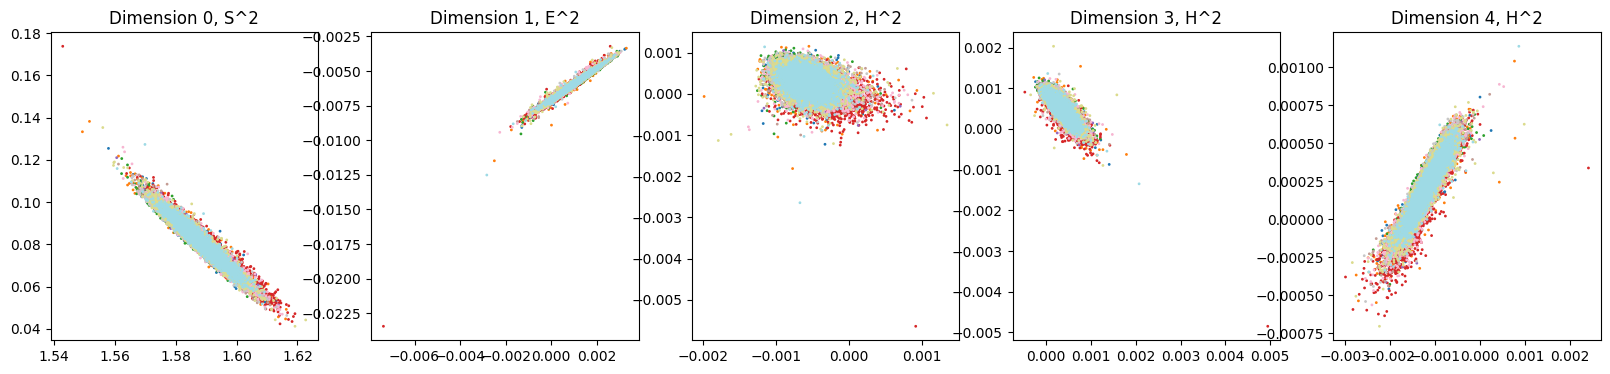

In [20]:
# Let's visualize the embeddings

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, ax in enumerate(axs):
    M = pm.P[i]
    to_plot = torch.Tensor(embeddings[:, pm.man2dim[i]])
    if M.type == "S":
        to_plot = embedders.visualization.S2_to_polar(to_plot)
    elif M.type == "H":
        to_plot = embedders.visualization.hyperboloid_to_poincare(to_plot)
    to_plot = to_plot.numpy()
    ax.set_title(f"Dimension {i}, {M.type}^{M.dim}")
    ax.scatter(to_plot[:, 0], to_plot[:, 1], s=1, c=[int(x) for x in adata.obs["cell_type"]], cmap="tab20")

# Evaluate classification accuracy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import anndata

import embedders

# from hyperdt.product_space_DT import ProductSpaceDT
# from hyperdt.forest import ProductSpaceRF

# from embedders.tree import TorchProductSpaceDT as ProductSpaceDT
# from embedders.tree import TorchProductSpaceRF as ProductSpaceRF
from embedders.tree_new import ProductSpaceDT, ProductSpaceRF

# from hyperdt.torch.forest import ProductSpaceRF

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [5]:
# Device

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [6]:
# Load data

X = torch.tensor(np.load("../data/blood_cell_scrna/embeddings_s2_e2_h2_3.npy"), requires_grad=False)
idx = np.random.choice(X.shape[0], 1_000, replace=False)
# X = X[idx]  # Take it easy

y = torch.tensor(
    [int(x) for x in anndata.read_h5ad("../data/blood_cell_scrna/adata.h5ad").obs["cell_type"]],
    requires_grad=False,
)
# y = y[idx]  # Take it easy

X = X.to(device)
y = y.to(device)

X.shape, y.shape

(torch.Size([94655, 14]), torch.Size([94655]))

In [7]:
SIGNATURE = [(1, 2), (0, 2), (-1, 2), (-1, 2), (-1, 2)]
pm = embedders.manifolds.ProductManifold(SIGNATURE, device=device)

# Downsample
# DOWNSAMPLE = 100  # About 2 mins, somehow
# DOWNSAMPLE = 100  # About 2 mins
# DOWNSAMPLE = 2_000  # About 4 mins
# DOWNSAMPLE = 10_000 # 4 mins on GPU
DOWNSAMPLE = None
MAX_DEPTH = 5
BATCH_SIZE = 1

# idx = np.random.choice(len(X), DOWNSAMPLE, replace=False)
idx = torch.randperm(len(X))[:DOWNSAMPLE]
X_sample = X[idx]
y_sample = y[idx]

kf = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

f1s_dt, f1s_pdt, f1s_rf, f1s_prf = [], [], [], []
accs_dt, accs_pdt, accs_rf, accs_prf = [], [], [], []

for train_index, test_index in kf.split(X_sample):
    test_index, train_index = train_index, test_index  # Hack to do 20% train, 80% test
    X_train, X_test = X_sample[train_index], X_sample[test_index]
    y_train, y_test = y_sample[train_index], y_sample[test_index]

    # X_train_np, X_test_np = X_train.detach().cpu().numpy(), X_test.detach().cpu().numpy()
    # y_train_np, y_test_np = y_train.detach().cpu().numpy(), y_test.detach().cpu().numpy()

    X_train, X_test, y_train, y_test = X_train.to("cpu"), X_test.to("cpu"), y_train.to("cpu"), y_test.to("cpu")

    dt = DecisionTreeClassifier(max_depth=MAX_DEPTH)
    dt.fit(X_train, y_train)
    f1s_dt.append(f1_score(y_test, dt.predict(X_test), average="micro"))
    accs_dt.append(accuracy_score(y_test, dt.predict(X_test)))
    print(".", end="")

    rf = RandomForestClassifier(max_depth=MAX_DEPTH, n_estimators=12)
    rf.fit(X_train, y_train)
    f1s_rf.append(f1_score(y_test, rf.predict(X_test), average="micro"))
    accs_rf.append(accuracy_score(y_test, rf.predict(X_test)))
    print(".", end="")

    y_test_np = y_test
    X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

    pdt = ProductSpaceDT(max_depth=MAX_DEPTH, pm=pm, batch_size=BATCH_SIZE)
    pdt.fit(X_train, y_train)
    pdt_pred = pdt.predict(X_test).detach().cpu().numpy()
    f1s_pdt.append(f1_score(y_test_np, pdt_pred, average="micro"))
    accs_pdt.append(accuracy_score(y_test_np, pdt_pred))
    print(".", end="")

    prf = ProductSpaceRF(max_depth=MAX_DEPTH, n_estimators=12, pm=pm, batch_size=BATCH_SIZE)
    for tree in prf.trees:
        tree.pm = tree.pm.to(device)
    prf.fit(X_train, y_train)
    prf_pred = prf.predict(X_test).detach().cpu().numpy()
    f1s_prf.append(f1_score(y_test_np, prf_pred, average="micro"))
    accs_prf.append(accuracy_score(y_test_np, prf_pred))

    print(".", end="")
    print()

print()
print(f"Decision Tree: {np.mean(f1s_dt):.3f}")
print(f"Random Forest: {np.mean(f1s_rf):.3f}")
print(f"Product Space Decision Tree: {np.mean(f1s_pdt):.3f}")
print(f"Product Space Random Forest: {np.mean(f1s_prf):.3f}")

print()
print(f"Decision Tree: {np.mean(accs_dt):.3f}")
print(f"Random Forest: {np.mean(accs_rf):.3f}")
print(f"Product Space Decision Tree: {np.mean(accs_pdt):.3f}")
print(f"Product Space Random Forest: {np.mean(accs_prf):.3f}")

..

Calculating information gains:   0%|          | 0/189310 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/75990 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/21100 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/10690 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/5790 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/4900 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/10410 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/6960 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/3450 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/54890 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/34570 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/6100 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/28470 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/20320 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/13600 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/6720 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/113320 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/76110 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/18220 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/16030 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/2190 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/57890 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/16470 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/41420 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/37210 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/12960 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/1080 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/11880 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/24250 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/5800 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/18450 [00:00<?, ?it/s]